# Study of Covid data as published by the NYT

In [236]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [237]:
matplotlib.style.use('seaborn')

In [238]:
import geopandas as gpd

In [239]:
import geoplot as gplt
import geoplot.crs as gcrs

Set the style for the graphs

## Get NYT Data and prepare the data

In [240]:
df = pd.read_csv('us-states.csv')
df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


### Make the dates strings into Timestamp objects

In [241]:
df.dtypes

date      object
state     object
fips       int64
cases      int64
deaths     int64
dtype: object

In [242]:
df['date']=df['date'].apply(lambda x:pd.Timestamp(x))
df.dtypes

date      datetime64[ns]
state             object
fips               int64
cases              int64
deaths             int64
dtype: object

### Set the date as index

For easier data slicing based on dates, make the date column the index

In [243]:
df.set_index('date',inplace=True)
df.head()

,state,fips,cases,deaths
date,,,,
2020-01-21,Washington,53,1,0
2020-01-22,Washington,53,1,0
2020-01-23,Washington,53,1,0
2020-01-24,Illinois,17,1,0
2020-01-24,Washington,53,1,0


### Plot the evolution of number of cases per state

In [244]:
def my_plotter(fig,ax,df,state,column):
    '''
    Helper function to make the graphs
    '''
    fig.set_size_inches(10,6)
    ax.set_title(f"Evolution of cases per State")
    # x formatter for dates
    ax.get_xaxis().set_major_formatter(matplotlib.dates.DateFormatter(fmt='%m-%d'))
    # y formatter for thousands separator
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,p: format(int(x),',')))
    out = ax.plot( df[df['state']==state].loc['20200301':].index , df[df['state']==state].loc['20200301':,[column]],label=state )
    ax.legend()
    return out

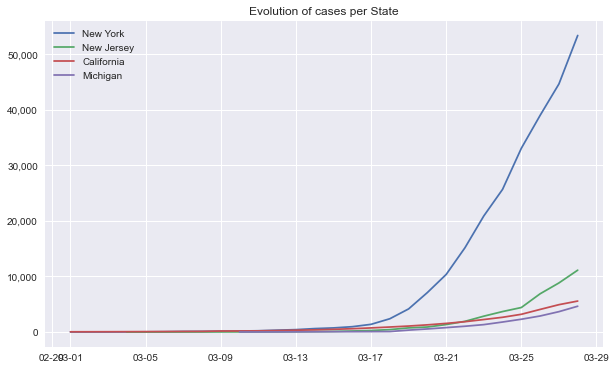

In [245]:
fig,ax = plt.subplots()
my_plotter(fig,ax,df,state='New York',column="cases")
my_plotter(fig,ax,df,state='New Jersey',column="cases")
my_plotter(fig,ax,df,state='California',column="cases")
out = my_plotter(fig,ax,df,state='Michigan',column="cases")

## Sates ranked per number of cases

In [246]:
df['20200328':].sort_values(by='cases',ascending=False).head(10)

,state,fips,cases,deaths
date,,,,
2020-03-28,New York,36,53363,782
2020-03-28,New Jersey,34,11124,140
2020-03-28,California,6,5565,121
2020-03-28,Michigan,26,4635,111
2020-03-28,Washington,53,4311,191
2020-03-28,Massachusetts,25,4257,44
2020-03-28,Florida,12,4038,56
2020-03-28,Illinois,17,3547,50
2020-03-28,Louisiana,22,3315,137


## GEO VISUALIZATON

In [247]:
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
usa_cities = gpd.read_file(gplt.datasets.get_path('usa_cities'))
continental_usa_cities = usa_cities.query('STATE not in ["HI", "AK", "PR"]')

### USA States

In [248]:
contiguous_usa.head()

,state,adm1_code,population,geometry
0,Minnesota,USA-3514,5303925,"POLYGON ((-89.59941 48.01027, -89.48888 48.013..."
1,Montana,USA-3515,989415,"POLYGON ((-111.19419 44.56116, -111.29155 44.7..."
2,North Dakota,USA-3516,672591,"POLYGON ((-96.60136 46.35136, -96.53891 46.199..."
3,Idaho,USA-3518,1567582,"POLYGON ((-111.04973 44.48816, -111.05025 42.0..."
4,Washington,USA-3519,6724540,"POLYGON ((-116.99807 46.33017, -116.90653 46.1..."


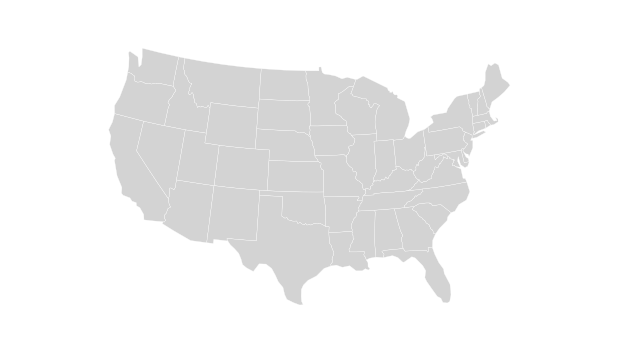

In [249]:
# USA Country map
ax = gplt.polyplot(contiguous_usa,projection=gcrs.AlbersEqualArea(),figsize=(11,8),
                  edgecolor='white',facecolor='lightgray')

### USA States center point (centroid of the polygon)

In [250]:
states_centroids = contiguous_usa.copy()

In [251]:
states_centroids['geometry'] = states_centroids['geometry'].apply(lambda x:x.centroid,)
states_centroids.head()

,state,adm1_code,population,geometry
0,Minnesota,USA-3514,5303925,POINT (-94.17744 46.36007)
1,Montana,USA-3515,989415,POINT (-109.65900 47.04846)
2,North Dakota,USA-3516,672591,POINT (-100.48470 47.46271)
3,Idaho,USA-3518,1567582,POINT (-114.65497 44.39401)
4,Washington,USA-3519,6724540,POINT (-120.39837 47.37975)


### Preparing data for Geo visualization

In [252]:
states_centroids.head()

,state,adm1_code,population,geometry
0,Minnesota,USA-3514,5303925,POINT (-94.17744 46.36007)
1,Montana,USA-3515,989415,POINT (-109.65900 47.04846)
2,North Dakota,USA-3516,672591,POINT (-100.48470 47.46271)
3,Idaho,USA-3518,1567582,POINT (-114.65497 44.39401)
4,Washington,USA-3519,6724540,POINT (-120.39837 47.37975)


In [253]:
geodata = pd.merge(left=df,right=states_centroids,how='inner',on='state',right_index=True)
geodata.loc['20200328'].sort_values(by='fips').head()

,state,fips,cases,deaths,adm1_code,population,geometry
date,,,,,,,
2020-03-28,Alabama,1,720,4,USA-3541,4779736,POINT (-86.82818 32.77371)
2020-03-28,Arizona,4,773,15,USA-3520,6392017,POINT (-111.65946 34.29560)
2020-03-28,Arkansas,5,409,5,USA-3528,2915918,POINT (-92.44486 34.92181)
2020-03-28,California,6,5565,121,USA-3521,37253956,POINT (-119.64054 37.25514)
2020-03-28,Colorado,8,2061,44,USA-3522,5029196,POINT (-105.54544 39.00008)


In [254]:
geodata = gpd.GeoDataFrame(geodata)

### Plotting States centroids on the USA Map

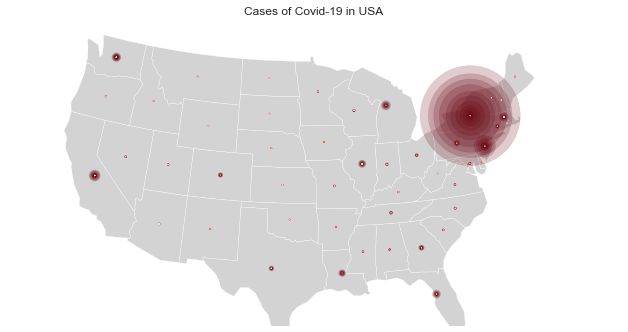

In [255]:
# USA Country map
ax = gplt.polyplot(contiguous_usa,projection=gcrs.AlbersEqualArea(),figsize=(11,8),
                  edgecolor='white',facecolor='lightgray')

# Points per State
gplt.pointplot(
    geodata, ax=ax, hue='cases', cmap='Reds', alpha=0.2,
    scheme='quantiles',
    scale='cases', limits=(1, 100)
)

title_text = ax.set_title('Cases of Covid-19 in USA')